# iSCAT Analysis Demo

This notebook demonstrates the analysis of multiple tracks at once using the `ListOfTracks` class.

In [1]:
from iscat_lib.analysis import ListOfTracks

Load the tracks from some example data. We can use `tracks.normalize` to set the initial time value of all tracks to 0.

In [2]:
tracks = ListOfTracks.from_file("../examples/more test data/180912 20nm GoldNP on 75DOPC25Chol (2kHz 100pc power)_Position_converted_fixed.csv", unit_length='micrometres')
tracks.normalize(normalize_t = True, normalize_xy = False)

c:\users\john\projekte\iscat_analysis\iscat_lib\analysis.py:1188: UserWarning: Track is not very long, switching to single worker as this will probably be faster than setting up the process pool. Use num_workers = 1 to suppress this warning.
  warnings.warn("Track is not very long, switching to single worker as "


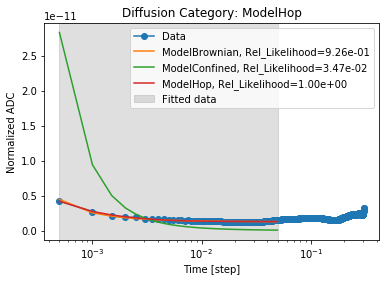

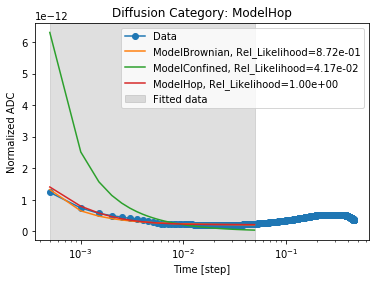

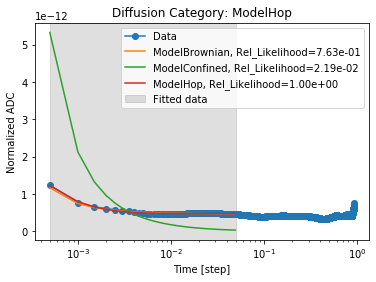

In [3]:
tracks_hop = ListOfTracks([tracks.get_track(10), tracks.get_track(25), tracks.get_track(221)])
tracks_hop.adc_analysis(fit_max_time=50e-3)
tracks_hop.get_track(0).plot_adc_analysis_results()
tracks_hop.get_track(1).plot_adc_analysis_results()
tracks_hop.get_track(2).plot_adc_analysis_results()

c:\users\john\projekte\iscat_analysis\iscat_lib\analysis.py:1188: UserWarning: Track is not very long, switching to single worker as this will probably be faster than setting up the process pool. Use num_workers = 1 to suppress this warning.
  warnings.warn("Track is not very long, switching to single worker as "


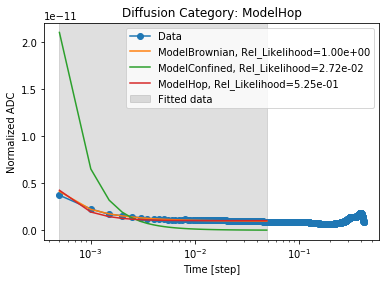

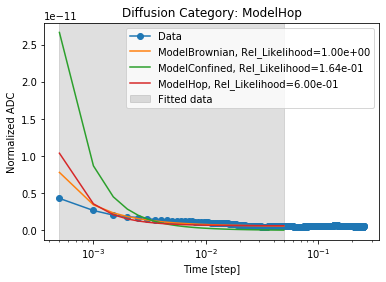

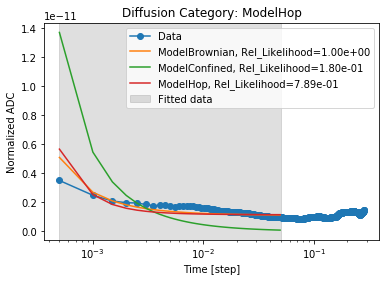

In [4]:
tracks_brownian = ListOfTracks([tracks.get_track(0), tracks.get_track(7), tracks.get_track(9)])
tracks_brownian.adc_analysis(fit_max_time=50e-3)
tracks_brownian.get_track(0).plot_adc_analysis_results()
tracks_brownian.get_track(1).plot_adc_analysis_results()
tracks_brownian.get_track(2).plot_adc_analysis_results()

c:\users\john\projekte\iscat_analysis\iscat_lib\analysis.py:91: RuntimeWarning: divide by zero encountered in true_divide
  D_micro * (tau/t) * (1 - np.exp(-tau/t)) + \
c:\users\john\projekte\iscat_analysis\iscat_lib\analysis.py:92: RuntimeWarning: divide by zero encountered in true_divide
  delta ** 2 / (2 * t * (1 - 2 * self.R * self.dt / t))
c:\users\john\projekte\iscat_analysis\iscat_lib\analysis.py:92: RuntimeWarning: invalid value encountered in multiply
  delta ** 2 / (2 * t * (1 - 2 * self.R * self.dt / t))


{'sectors': {'ModelHop': 1.0},
 'average_params': {'ModelHop': array([6.57423914e-13, 2.03366483e-13, 1.76024298e-23, 3.88928540e-03])},
 'average_msd': {'ModelHop': array([2.98409043e-15, 4.69259962e-15, 5.91789532e-15, ...,
         2.52520028e-12, 2.56074372e-12, 2.77766455e-12])},
 'average_dapp': {'ModelHop': array([2.23806782e-12, 1.40777989e-12, 1.10960537e-12, ...,
         6.84088931e-13, 6.93342162e-13, 7.51668198e-13])}}

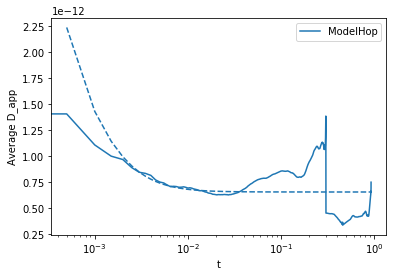

In [5]:
tracks_hop.summary(plot_dapp=True)

c:\users\john\projekte\iscat_analysis\iscat_lib\analysis.py:49: RuntimeWarning: divide by zero encountered in true_divide
  return D + delta**2 / (2*t*(1-2*self.R*self.dt/t))
c:\users\john\projekte\iscat_analysis\iscat_lib\analysis.py:49: RuntimeWarning: invalid value encountered in multiply
  return D + delta**2 / (2*t*(1-2*self.R*self.dt/t))


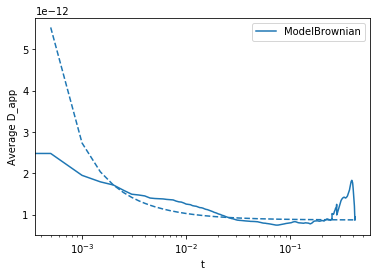

In [6]:
tracks_brownian.summary(plot_dapp=True);

In [7]:
tracks_both = ListOfTracks(tracks_brownian.get_tracks() + tracks_hop.get_tracks())

No handles with labels found to put in legend.


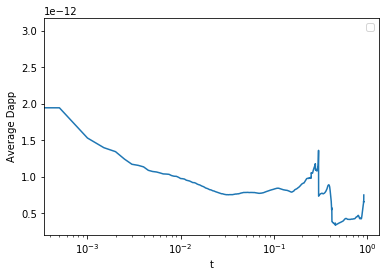

In [8]:
tracks_both.plot_dapp()

In [9]:
import numpy as np
class ModelHopModified:
    """Model for hop diffusion.
    
    Parameters
    ----------
    R: float
        Point scanning across the field of view.
    dt: float
        Uniform time step size.
    """
    lower = [0.0, 0.0, 0.0, 0.0]
    upper = np.inf
    initial = [0.5e-12, 0.5e-12, 0.0, 1.0e-3]
    def __init__(self, R):
        self.R = R
        self.dt = 0.0

    def __call__(self, t, D_macro, D_micro, alpha, tau):
        return alpha * D_macro + \
            (1.0 - alpha) * D_micro * (1 - np.exp(-t/tau))

In [10]:
from iscat_lib.analysis import ModelDB
from iscat_lib.analysis import ModelHop
ModelDB().remove_model(ModelHop)
ModelDB().add_model(ModelHopModified(1.0/6.0))

In [19]:
tracks_hop.get_track(0).adc_analysis()

{'analyzed': True,
 'model': 'ModelBrownian',
 'Dapp': array([4.23597833e-12, 2.70423784e-12, 2.09520127e-12, 1.89237716e-12,
        1.86959412e-12, 1.70486054e-12, 1.61598918e-12, 1.63675778e-12,
        1.62295997e-12, 1.53446324e-12, 1.51746191e-12, 1.52277981e-12,
        1.47291895e-12, 1.43370144e-12, 1.44752245e-12, 1.43477487e-12,
        1.40612614e-12, 1.40377314e-12, 1.40918744e-12, 1.39354338e-12,
        1.37369093e-12, 1.38618533e-12, 1.38175026e-12, 1.36676072e-12,
        1.36065482e-12, 1.35316211e-12, 1.33374707e-12, 1.32268279e-12,
        1.32699460e-12, 1.31004096e-12, 1.28538811e-12, 1.27165297e-12,
        1.26084858e-12, 1.23721065e-12, 1.22990336e-12, 1.22823529e-12,
        1.22031462e-12, 1.20852700e-12, 1.21103116e-12, 1.20712505e-12,
        1.20246039e-12, 1.19544650e-12, 1.20081181e-12, 1.19587461e-12,
        1.18755825e-12, 1.18736500e-12, 1.18681678e-12, 1.18416219e-12,
        1.18850944e-12, 1.19218914e-12, 1.19044439e-12, 1.18848645e-12,
        1.

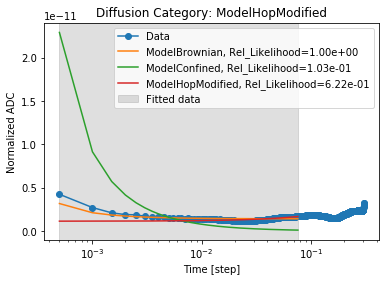

In [21]:
tracks_hop.get_track(0).plot_adc_analysis_results()